In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import logging


from diffusers import SD3Transformer2DModel, AutoencoderKL, FlowMatchEulerDiscreteScheduler
from transformers import CLIPTextModelWithProjection, CLIPTokenizer, T5EncoderModel, T5TokenizerFast

from diffusers.training_utils import compute_density_for_timestep_sampling, compute_loss_weighting_for_sd3, free_memory


from text_embed import encode_prompt, get_precomputed_tensors
from datasets import FillDataset
from sd3 import SD3CNModel, get_sigmas
from controlnext import ControlNeXtModel

2024-11-05 17:07:16.310828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 17:07:16.310874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 17:07:16.312063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 17:07:16.318600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 17:07:17.025321: W tensorflow/compiler/tf2

In [3]:
device = 'cuda:0'

In [4]:
# transformer = SD3CNModel.from_pretrained(
#     "stabilityai/stable-diffusion-3-medium-diffusers",
#     subfolder="transformer",
#     torch_dtype=torch.float16).to(device)
transformer = SD3CNModel.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    subfolder="transformer",).to(device)

In [5]:
vae = AutoencoderKL.from_pretrained(
            "stabilityai/stable-diffusion-3-medium",
            subfolder="vae",
            revision="refs/pr/26").to(device)

In [6]:
noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", subfolder="scheduler"
)
noise_scheduler_copy = copy.deepcopy(noise_scheduler)

In [9]:
tensor_list = get_precomputed_tensors(device=device)
        
pixel_list = [x['img'] for x in tensor_list]
hint_list = [x['hint'] for x in tensor_list]
prompt_embed_list = [x['prompt_embeds'] for x in tensor_list]
pooled_prompt_embed_list = [x['pooled_prompt_embeds'] for x in tensor_list]

In [10]:
model_input = vae.encode(pixel_list[0]).latent_dist.sample()
model_input = (model_input - vae.config.shift_factor) * vae.config.scaling_factor

In [11]:
# control_input = vae.encode(hint_list[0]).latent_dist.sample()
# control_input = (control_input - vae.config.shift_factor) * vae.config.scaling_factor

In [12]:
# Sample noise that we'll add to the latents
noise = torch.randn_like(model_input)
bsz = model_input.shape[0]
# Sample a random timestep for each image
# for weighting schemes where we sample timesteps non-uniformly
u = compute_density_for_timestep_sampling(
    weighting_scheme="logit_normal",
    batch_size=1,
    logit_mean=0,
    logit_std=1,
    mode_scale=1.29,
)

In [13]:
indices = (u * noise_scheduler_copy.config.num_train_timesteps).long()
timesteps = noise_scheduler_copy.timesteps[indices].to(device=model_input.device)

# Add noise according to flow matching.
# zt = (1 - texp) * x + texp * z1
sigmas = get_sigmas(timesteps, noise_scheduler_copy, n_dim=model_input.ndim, dtype=model_input.dtype, device=device)
noisy_model_input = (1.0 - sigmas) * model_input + sigmas * noise

In [40]:
control_next = ControlNeXtModel(upscale_dim=1536).to(device)
# control_next_model = ControlNeXtModel().to(device)

res = control_next(hint_list[0], timesteps)
control_out = res['output']

/home/sj/diffusers/src/diffusers/models/downsampling.py:135: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)


In [15]:
control_out.shape

torch.Size([1, 1024, 1536])

In [16]:
# Get the text embedding for conditioning
prompt_embeds = prompt_embed_list[0].to(device)
pooled_prompt_embeds = pooled_prompt_embed_list[0].to(device)



In [17]:
print(noisy_model_input.dtype, noisy_model_input.device)
print(timesteps.dtype, timesteps.device)
print(prompt_embeds.dtype, prompt_embeds.device)
print(pooled_prompt_embeds.dtype, pooled_prompt_embeds.device)


torch.float32 cuda:0
torch.float32 cuda:0
torch.float32 cuda:0
torch.float32 cuda:0


In [18]:
# Predict the noise residual
model_pred = transformer(
    hidden_states=noisy_model_input,
    timestep=timesteps,
    encoder_hidden_states=prompt_embeds,
    pooled_projections=pooled_prompt_embeds,
    controlnet_hidden_states=control_out,
    return_dict=False,
)[0]

In [20]:
model_pred.shape

torch.Size([1, 16, 64, 64])

In [29]:
decoded = vae.decode(model_pred).sample.cpu().detach().squeeze().permute(1,2,0)
min_val = decoded.min()
max_val = decoded.max()
decoded = (decoded - min_val) / (max_val - min_val)

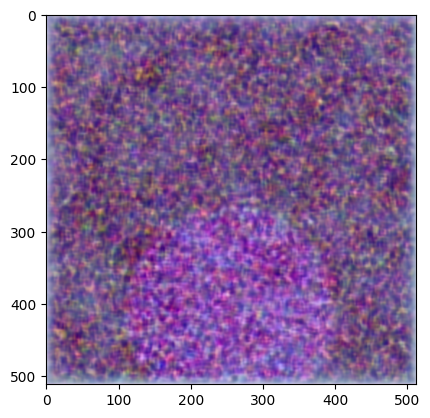

In [30]:
plt.imshow(decoded)

In [37]:
from trainer import retrieve_timesteps, get_scheduler



In [42]:
learning_rate = 1e-4
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 1e-4
adam_epsilon = 1e-8


params_to_optimize = list(transformer.parameters()) + list(control_next.parameters())

optimizer = torch.optim.AdamW(
    params_to_optimize,
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

In [43]:
scheduler_type = "constant"
lr_warmup_steps = 500
max_train_steps = 1000
lr_num_cycles = 1
lr_power = 1.0

lr_scheduler = get_scheduler(
    scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=max_train_steps,
    num_cycles=lr_num_cycles,
    power=lr_power,
) 

In [55]:
def generate_image(transformer, scheduler, num_inference_steps, device):
    timesteps, num_inference_steps = retrieve_timesteps(scheduler, num_inference_steps, device, None)
    num_warmup_steps = max(len(timesteps) - num_inference_steps * scheduler.order, 0)

    
    for i, t in enumerate(timesteps):

        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timestep = t.expand(latent_model_input.shape[0])

        noise_pred = transformer(
            hidden_states=latent_model_input,
            timestep=timestep,
            encoder_hidden_states=prompt_embeds,
            pooled_projections=pooled_prompt_embeds,
            joint_attention_kwargs=self.joint_attention_kwargs,
            return_dict=False,
        )[0]

        # compute the previous noisy sample x_t -> x_t-1
        latents_dtype = latents.dtype
        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]


In [97]:
def generate_image(transformer, scheduler, text_embeddings, pooled_text_embeddings, epoch, device, batch_size=1, num_inference_steps=1000):
    num_channels_latents = transformer.config.in_channels
    height, width = 64, 64  # Latent space dimensions (depends on your model)
    
    # Generate random latent noise
    latents = torch.randn((batch_size, num_channels_latents, height, width))
    latents = latents.to(transformer.device)
    
    # Set number of inference steps
    timesteps, num_inference_steps = retrieve_timesteps(scheduler, num_inference_steps=num_inference_steps)
    timesteps = timesteps.to(device)
    # latents = latents * scheduler.init_noise_sigma
    
    # Iteratively denoise latents
    for index, t in enumerate(timesteps):
        
        if (index + 1) % (num_inference_steps / 10) == 0:
            print(t)
            # Decode latents to an image
            with torch.no_grad():
                # latents = 1 / 0.18215 * latents
                image = vae.decode(latents).sample
            
            # Post-process image
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()
            
            # Convert the numpy array to a PIL image
            pil_image = Image.fromarray((image[0] * 255).astype(np.uint8))
            pil_image.save(f"gen_images/{epoch}_{index}.png")
            pil_image.show()
        
        # Predict the noise residual
        with torch.no_grad():
            noise_pred = transformer(latents, timestep=t.view(-1), encoder_hidden_states=text_embeddings, pooled_projections=pooled_text_embeddings).sample
    
        # Compute the previous noisy sample
        latents = scheduler.step(noise_pred, t.view(-1), latents).prev_sample

In [84]:
scheduler = FlowMatchEulerDiscreteScheduler()

In [98]:
generate_image(transformer, scheduler, prompt_embeds[0], num_inference_steps=1000)

AttributeError: 'NoneType' object has no attribute 'dtype'

In [142]:
text_embeddings = prompt_embeds[0].to(device)
pooled_projections = pooled_prompt_embeds[0].to(device)


In [143]:
from PIL import Image
import numpy as np

tensor(901., device='cuda:0')


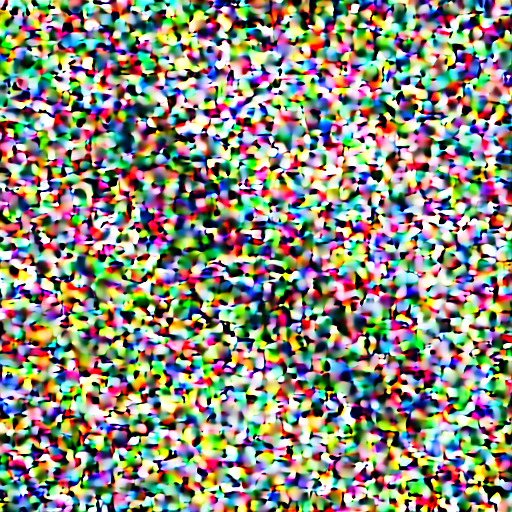

tensor(801., device='cuda:0')


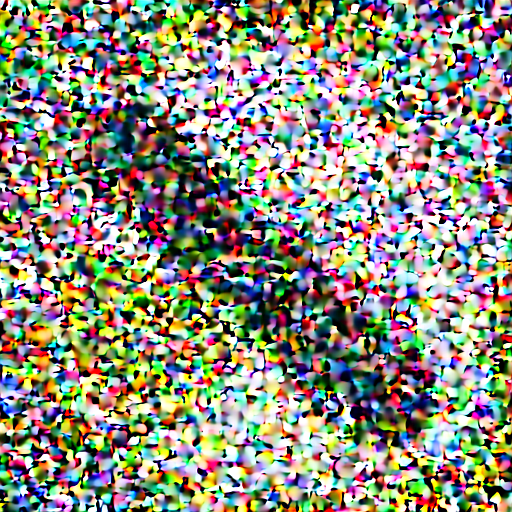

tensor(701., device='cuda:0')


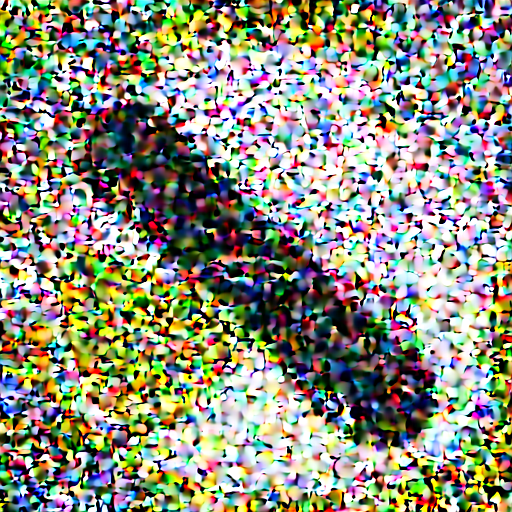

tensor(601., device='cuda:0')


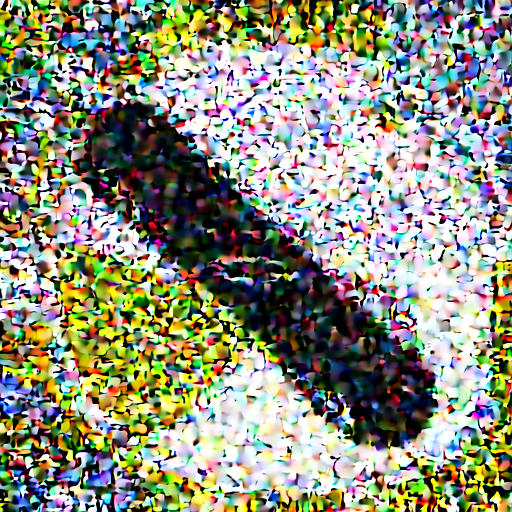

tensor(501., device='cuda:0')


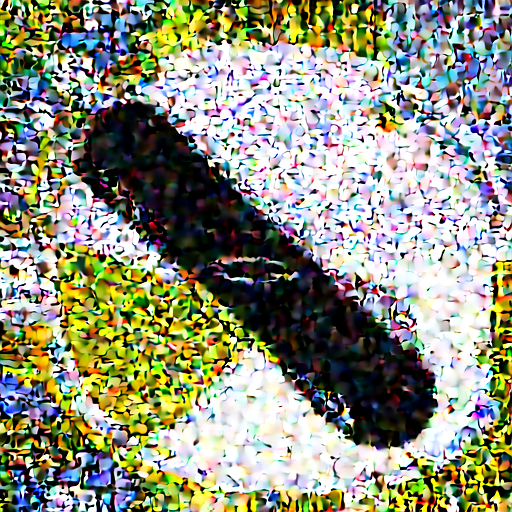

tensor(401., device='cuda:0')


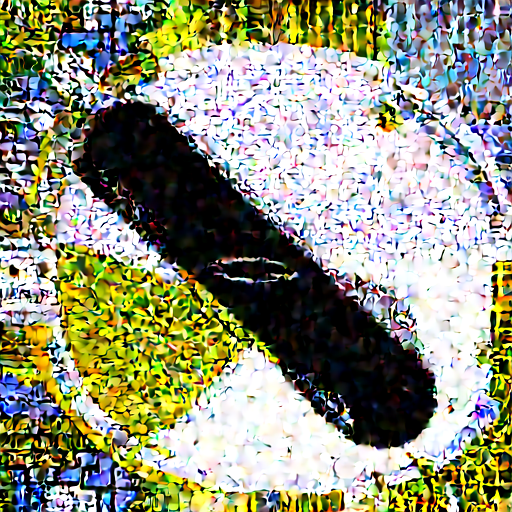

tensor(301., device='cuda:0')


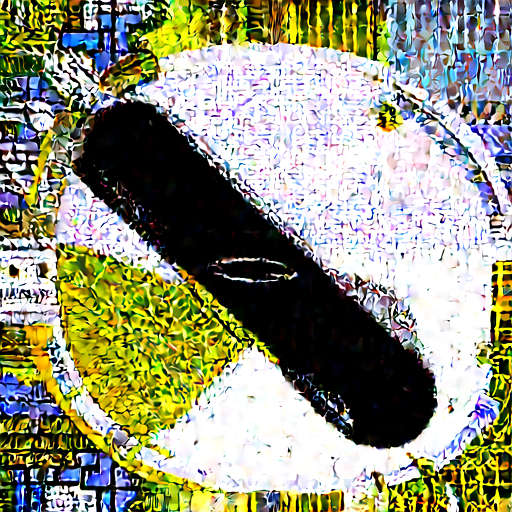

tensor(201., device='cuda:0')


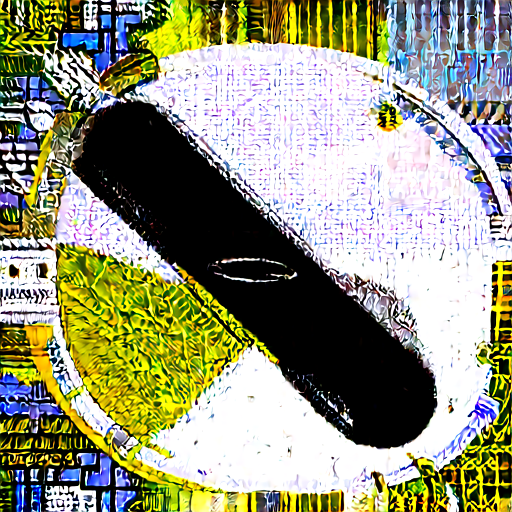

tensor(101., device='cuda:0')


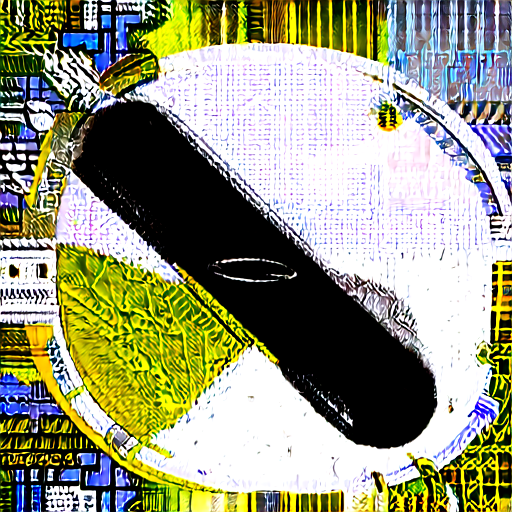

tensor(1., device='cuda:0')


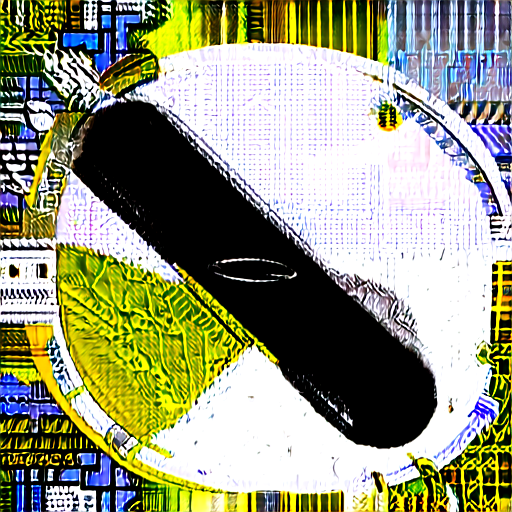

In [152]:
num_inference_steps = 1000

batch_size = 1
num_channels_latents = transformer.config.in_channels
height, width = 64, 64  # Latent space dimensions (depends on your model)

# Generate random latent noise
latents = torch.randn((batch_size, num_channels_latents, height, width))
latents = latents.to(transformer.device)

# Set number of inference steps
timesteps, num_inference_steps = retrieve_timesteps(scheduler, num_inference_steps=num_inference_steps)
timesteps = timesteps.to(device)
# latents = latents * scheduler.init_noise_sigma

# Iteratively denoise latents
for index, t in enumerate(timesteps):
    
    if (index + 1) % (num_inference_steps / 10) == 0:
        print(t)
        # Decode latents to an image
        with torch.no_grad():
            # latents = 1 / 0.18215 * latents
            image = vae.decode(latents).sample
        
        # Post-process image
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        
        # Convert the numpy array to a PIL image
        pil_image = Image.fromarray((image[0] * 255).astype(np.uint8))
        # pil_image.save("generated_image.png")
        pil_image.show()
    
    # Predict the noise residual
    with torch.no_grad():
        noise_pred = transformer(latents, timestep=t.view(-1), encoder_hidden_states=text_embeddings, pooled_projections=pooled_projections).sample

    # Compute the previous noisy sample
    latents = scheduler.step(noise_pred, t.view(-1), latents).prev_sample

    